In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import sqlite3

### Importing dataset and merging them

In [17]:
df_1 = pd.read_csv("massgap.csv")
df_2 = pd.read_csv("no_massgap.csv")
df = pd.concat([df_1,df_2])
df = df.reset_index(drop=True)

### Imposing constraint (cfar < 1/month), (m1_rec <120), and label the data

In [18]:
df = df.loc[df['cfar'] < 3.86e-7]
df = df.loc[df['rec_m1'] < 120]

def conditions(df):
    if ((df['inj_mass1_source_frame'] > 3.0) & (df['inj_mass1_source_frame'] < 5.0)) | ((df['inj_mass2_source_frame'] > 3.0) & (df['inj_mass2_source_frame'] < 5.0)):
        return 1
    else:
        return 0
    
df['hasmassgap'] = df.apply(conditions, axis=1)
df = df.reset_index(drop=True)
df['hasmassgap'].value_counts()

0    189802
1     50724
Name: hasmassgap, dtype: int64

### Preparing dataset for training and testing


In [19]:
cols = ['rec_m1','rec_m2','rec_spin1z','rec_spin2z','snr','hasmassgap']
reduced_df = df.loc[:,cols]
reduced_df = reduced_df.rename(columns={"rec_m1" : "m1_rec", 
                                        "rec_m2" : "m2_rec", 
                                        "rec_spin1z" : "chi1_rec", 
                                        "rec_spin2z" : "chi2_rec", 
                                        "hasmassgap" : "s"})

In [20]:
train = reduced_df.sample(frac=0.7, random_state=300)
test = reduced_df.drop(train.index)
test = test.sample(frac=1, random_state=300)

### Implementing Random Forest


In [21]:
feature_cols = ["m1_rec", "m2_rec", "chi1_rec", "chi2_rec", "snr"]
category_cols = ["s"]
train_features = train[feature_cols]
train_targets = train[category_cols].squeeze()
test_features = test[feature_cols]
test_targets = test[category_cols].squeeze()

In [22]:
rf_kwargs = {'n_estimators':50, 
             'criterion':'gini', 
             'max_depth': 20, 
             'max_features': None, 
             'min_samples_leaf': 5, 
             'min_samples_split': 20}

In [23]:
clf = RandomForestClassifier(**rf_kwargs)
clf = clf.fit(train_features, train_targets)
score = clf.score(test_features, test_targets)
print("Score :", score)

Score : 0.9075916738268799


### Checking results on the testing set (ROC and histogram)

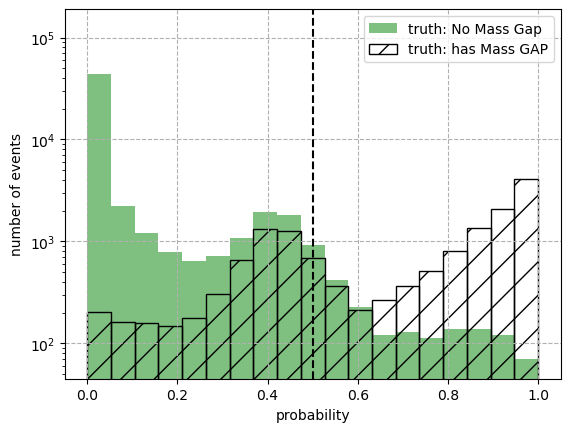

In [24]:
test['RF_MASS_GAP'] = clf.predict_proba(test_features)[:,1]

def hist_prob(df):
    pred=df['RF_MASS_GAP'].to_numpy()
    truelabel=df['s'].to_numpy()
    index_events_has=np.where(truelabel == 1)
    p_events_has=pred[index_events_has]
    index_events_nohas=np.where(truelabel==0)
    p_events_nohas=pred[index_events_nohas]
    return p_events_has, p_events_nohas


p_event_has_NS, p_event_nohas_NS = hist_prob(test)

fig, ax = plt.subplots()
ax.hist(p_event_nohas_NS,bins=np.linspace(0,1,20),color='green',alpha=0.5, label="truth: No Mass Gap")
ax.hist(p_event_has_NS,bins=np.linspace(0,1,20),color=(0.1, 0.2, 0.5, 0.),edgecolor='black', hatch="/", label= "truth: has Mass GAP")
ax.set_yscale('log')
ax.set_yticks([1e2,1e3,1e4,1e5])
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.set_ylim([4.5e1,1.9e5])
ax.set_xlabel('probability')
ax.set_ylabel('number of events')
ax.grid(ls='--')
ax.legend()
ax.axvline(x=0.5,color='black',ls='--')
plt.show()

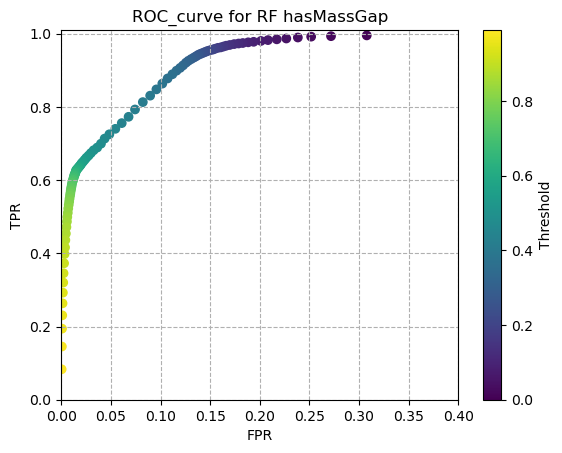

In [25]:
def ROC_curve(df):
    conf_matrix = pd.DataFrame(columns=['TN','FN','FP','TP'])
    for i in np.arange(0.00,1.00,0.01): 
        df["thresh"] = np.where(df['RF_MASS_GAP']>= i, 1.0, df['RF_MASS_GAP'])
        df["thresh"] = np.where(df["thresh"]!=1.0, 0.0, df["thresh"])
        FOMs = {0+0j:'TN', 1+0j:'FN',0+1j:'FP',1+1j:'TP'}
        winner_complex = df['s'] + 1j * df["thresh"]
        df["classified"] = winner_complex
        FOM_map = map (lambda x: FOMs[x], winner_complex) 
        df["classified"] = list(FOM_map)
        temp = pd.DataFrame(df["classified"].value_counts().to_dict(), index=[0])
        conf_matrix= pd.concat([conf_matrix,temp],ignore_index=True)
    conf_matrix = conf_matrix.reset_index(drop=True)
    conf_matrix = conf_matrix.fillna(0).astype(int)   
    conf_matrix['TPR'] = conf_matrix['TP']/(conf_matrix['TP']+conf_matrix['FN'])
    conf_matrix['TNR'] = conf_matrix['TN']/(conf_matrix['TN']+conf_matrix['FP'])
    conf_matrix['FNR'] = conf_matrix['FN']/(conf_matrix['FN']+conf_matrix['TP'])
    conf_matrix['FPR'] = conf_matrix['FP']/(conf_matrix['FP']+conf_matrix['TN'])
    conf_matrix['Threshold'] = np.arange(0.00,1.00,0.01)
    return conf_matrix

conf_matrix = ROC_curve(test)
fig, ax = plt.subplots()
im1 = ax.scatter(conf_matrix['FPR'],conf_matrix['TPR'], c=conf_matrix['Threshold'])
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_xlim(0.00,0.4)
ax.set_ylim(0.00,1.01)
cbar = fig.colorbar(im1)
cbar.set_label("Threshold")
ax.grid(linestyle = "--")
ax.set_title("ROC_curve for RF hasMassGap")
plt.show()

### Testing the classifier on MDC


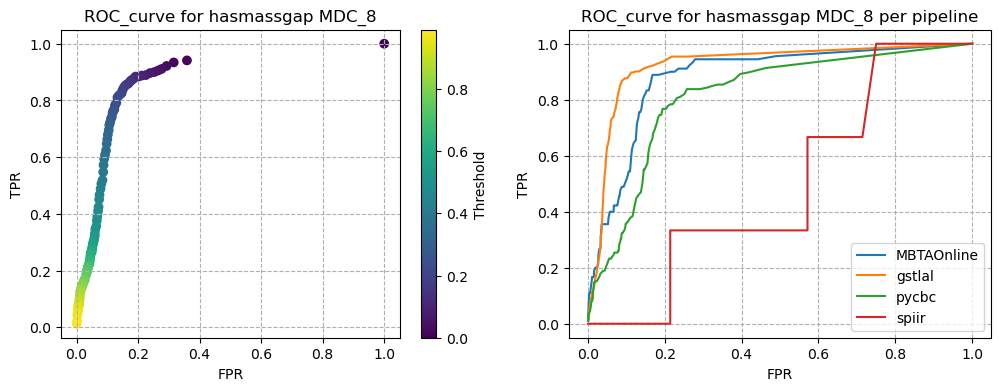

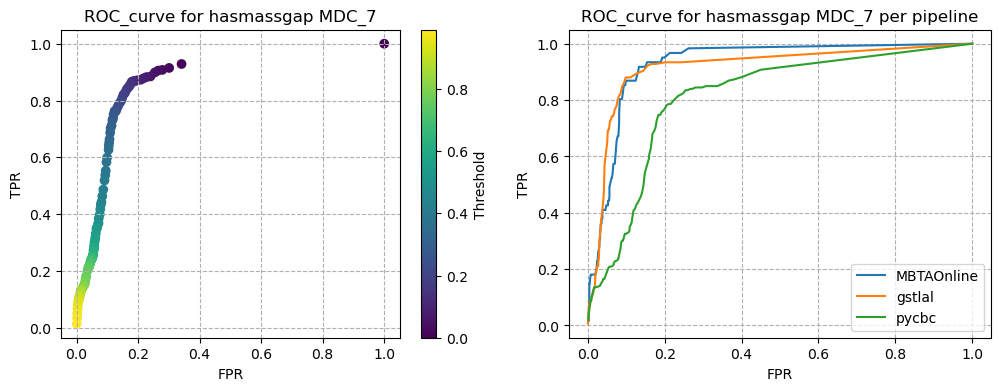

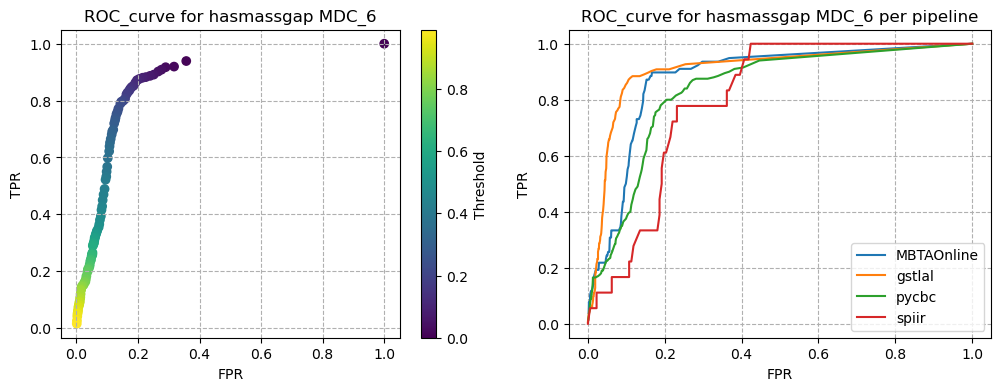

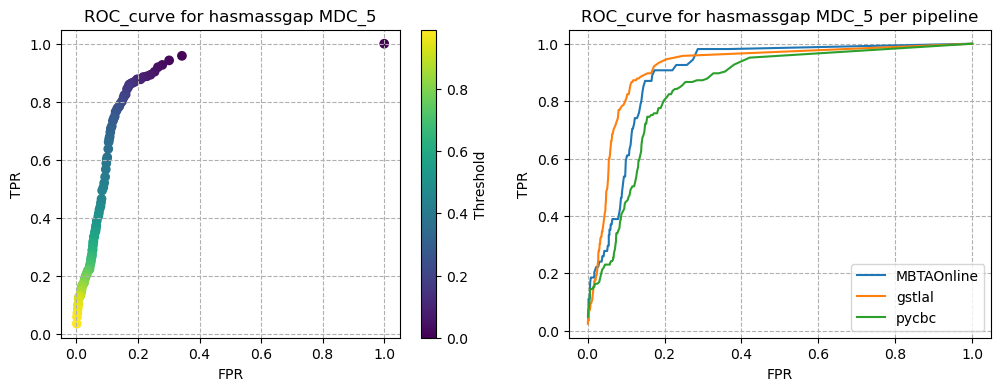

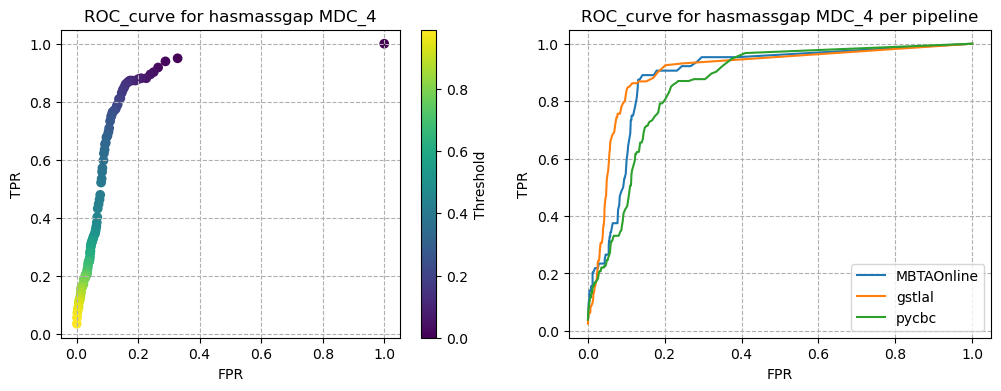

In [26]:
mdc_dict = {
             'MDC_8' : "MDC8_1350240000_1353696000.sqlite",  
             'MDC_7' : "MDC7_1346784000_1350240000.sqlite",
             'MDC_6' : "MDC6_1343328000_1346784000.sqlite",
             'MDC_5' : "MDC5_1339872000_1343328000.sqlite",
             'MDC_4' : "MDC4_1336416000_1339872000.sqlite"
            }

for mdc_name, filename in mdc_dict.items():
    cnx = sqlite3.connect(filename)
    mdc_df = pd.read_sql_query("SELECT * FROM events", cnx)
    mdc_df = mdc_df.loc[mdc_df.combined_far < 3.86e-7]
    mdc_df.pipeline = mdc_df.pipeline.replace("MBTA", "MBTAOnline")
    mdc_df['inj_mass1_source_frame'] = mdc_df['mass1_inj']/(1 + mdc_df['z_inj'])
    mdc_df['inj_mass2_source_frame'] = mdc_df['mass2_inj']/(1 + mdc_df['z_inj'])

    def conditions(df):
        if ((df['inj_mass1_source_frame'] > 3.0) & (df['inj_mass1_source_frame'] < 5.0)) | \
           ((df['inj_mass2_source_frame'] > 3.0) & (df['inj_mass2_source_frame'] < 5.0)):
            return 1
        else:
            return 0
    mdc_df['s'] = mdc_df.apply(conditions, axis=1)
    required_cols = ['mass1','mass2','spin1z', 'spin2z', 'combined_snr']
    required_data = mdc_df.loc[:,required_cols]
    required_data = required_data.rename(columns={"mass1" : "m1_rec", 
                                                  "mass2" : "m2_rec", 
                                                  "spin1z" : "chi1_rec", 
                                                  "spin2z" : "chi2_rec", 
                                                  "combined_snr" : "snr"})
    mdc_df['RF_MASS_GAP'] = clf.predict_proba(required_data)[:,1]
    temp = mdc_df.copy()
    conf_matrix_rf = ROC_curve(temp)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
    im1 = ax1.scatter(conf_matrix_rf['FPR'],conf_matrix_rf['TPR'], c=conf_matrix_rf['Threshold'])
    ax1.set_xlabel("FPR")
    ax1.set_ylabel("TPR")
    cbar1 = fig.colorbar(im1)
    cbar1.set_label("Threshold")
    ax1.grid(linestyle = "--")
    ax1.set_title("ROC_curve for hasmassgap {}".format(mdc_name))
    df_grouped_by_pipeline = mdc_df.groupby('pipeline') 
    
    for group, df_group in df_grouped_by_pipeline:
        df_group = df_group.reset_index(drop=True)
        temp = df_group.copy()
        has_mass_gap_conf_matrix_rf = ROC_curve(temp)
        ax2.plot(has_mass_gap_conf_matrix_rf['FPR'],has_mass_gap_conf_matrix_rf['TPR'], label=group )
        ax2.set_xlabel("FPR")
        ax2.set_ylabel("TPR") 
        ax2.legend()
        ax2.grid(linestyle = "--")
        ax2.set_title("ROC_curve for hasmassgap {} per pipeline".format(mdc_name))
    plt.show()


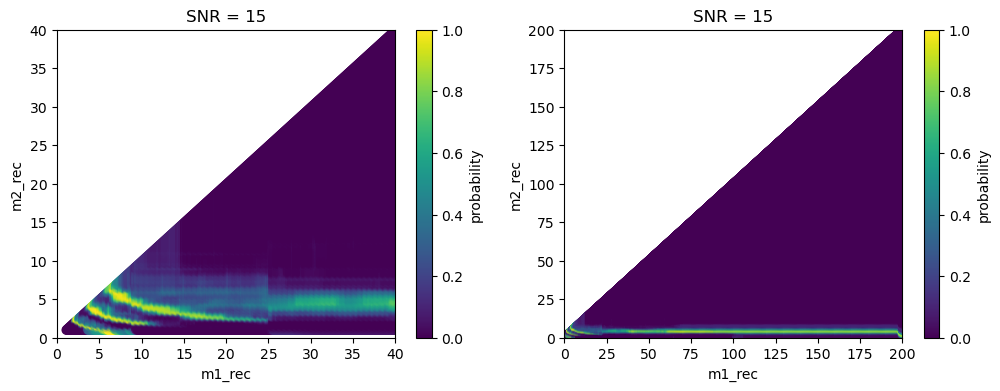

In [27]:
snr = 15
mass1 = np.linspace(1, 200, 2000)
mass2 = np.linspace(1, 200, 2000)
t = pd.DataFrame(np.vstack(
        (np.repeat(mass1, mass2.size),
            np.tile(mass2, mass1.size))
    ).T, columns=('m1_rec', 'm2_rec')
)
mask = t['m1_rec'] > t['m2_rec']
t = t[mask]
t = t.reset_index(drop=True)
t["chi1_rec"] = 0.0
t["chi2_rec"] = 0.0
t['snr'] = snr
t['prob'] = clf.predict_proba(t)[:, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
im1 = ax1.scatter(t['m1_rec'], t['m2_rec'], c=t['prob'])
ax1.set(xlabel='m1_rec', ylabel='m2_rec',
        xlim=(0, 40), ylim=(0, 40),
        title='SNR = {0}'.format(snr))
cbar1 = fig.colorbar(im1)
cbar1.set_label("probability")

im2 = ax2.scatter(t['m1_rec'], t['m2_rec'], c=t['prob'])
ax2.set(xlabel='m1_rec', ylabel='m2_rec',
        xlim=(0, 200), ylim=(0, 200),
        title='SNR = {0}'.format(snr))
cbar2 = fig.colorbar(im2)
cbar2.set_label("probability")
plt.show()


## Analysis of stripes


Text(0, 0.5, 'm2_rec')

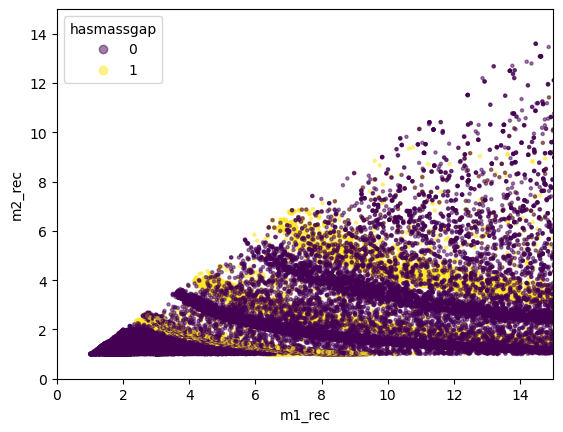

In [28]:
scatter = plt.scatter(df['rec_m1'], df['rec_m2'], c=df['hasmassgap'], s=5, alpha=0.5)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=[0,1],
           title="hasmassgap")
plt.xlim((0,15))
plt.ylim((0,15))
plt.xlabel("m1_rec")
plt.ylabel("m2_rec")

### The plot above is for the entire dataset. There are three stripes in the low mass region and the random forest algorithm is doing a great job recognising these.


Text(0.5, 1.0, 'Source mass1 histogram')

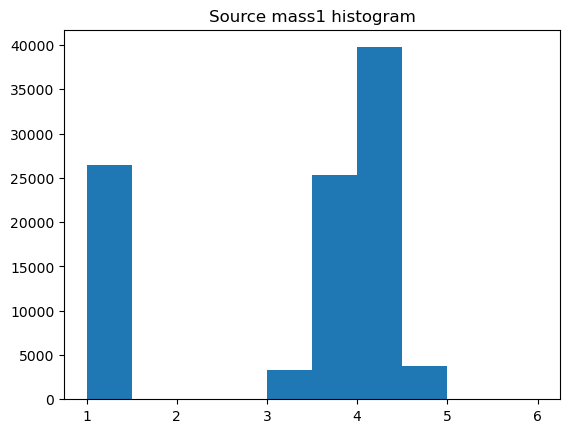

In [29]:
plt.hist(df_1['inj_mass1_source_frame'], range=(1,6), bins=10)
plt.title("Source mass1 histogram")

Text(0.5, 1.0, 'Source mass2 histogram')

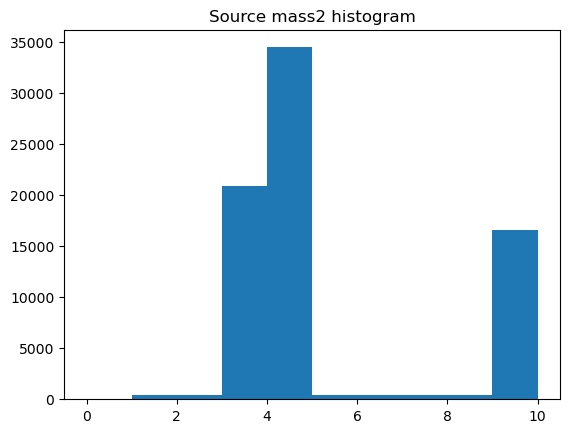

In [30]:
plt.hist(df_1['inj_mass2_source_frame'], range=(0,10))
plt.title("Source mass2 histogram")